## Adding new images from the real data 
To increase the accuracy of the model for detectin Guinness logo 100 new images were manually labeled and added to the data and model was re-trained with the new data

In [59]:
import pandas as pd
import numpy as np

import os
import cv2
from PIL import Image
import urllib.request

import tqdm
import warnings
warnings.filterwarnings('ignore')
import random
import re

from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras.utils

from sqlalchemy import create_engine, exc


In [55]:
df_beer = pd.read_csv('df_beer.csv')

In [56]:
df_beer

jpg      logo
0     guinness_55.jpg  guinness
1     guinness_74.jpg  guinness
2     guinness_37.jpg  guinness
3     guinness_19.jpg  guinness
4     guinness_15.jpg  guinness
...               ...       ...
9699   4595735316.jpg   no-logo
9700   4649353862.jpg   no-logo
9701   3060617157.jpg   no-logo
9702    652497606.jpg   no-logo
9703   3668548493.jpg   no-logo

[9704 rows x 2 columns]

In [53]:
PG = create_engine('POSTGRES CONNECTION STRING')
QUERY = '''select urls, date_time, logos from guinness where logos='no-logo limit 100' '''
images_to_label = PG.execute(QUERY).fetchall()

In [55]:
def image_labeler(QUERY):
    images_to_label = PG.execute(QUERY).fetchall()
    if not os.path.exists('scraped_images'):
        os.makedirs('scraped_images')
    image_list = os.listdir('scraped_images')
    
    image_numbers = []
    for image in image_list:
        if 'jpg' in image:
            last_number = re.findall("[0-9]+", image)
            last_number = int(last_number[0])    
            image_numbers.append(last_number)
    i = max(image_numbers) + 1
    
    for url in images_to_label:    
        img = Image.open(urllib.request.urlopen(url[0]))
        logo = url[2]
        print(logo)
        plt.imshow(img)
        plt.show()
        date_time = str(pd.to_datetime(url[1]))
        new_label = input()
        if new_label == 'g':
            new_label = 'guinness'
            img.save(f"./scraped_images/{new_label}_{i}.jpg")
        if new_label == '':
            pass
        else:
            img.save(f"./scraped_images/{new_label}_{i}.jpg")
        i = i + 1 
    

In [18]:
PATH = "./FlickrLogos-v2/flat/jpg/"
!cp /storage/logo_detection/scraped_images/* ./FlickrLogos-v2/flat/jpg/   # copying augmented images to the main data folder

In [30]:
def no_number(logo):
    label = re.findall('[a-z]+', logo)[0]
    return label
def update_dataframe(path):
    new_logos = os.listdir(path)
    new_logos.remove('.ipynb_checkpoints')
    df_new_logo = pd.DataFrame()
    df_new_logo['jpg'] = new_logos
    df_new_logo['logo'] = df_new_logo['jpg'].apply(no_number)
    df = pd.concat([df_new_logo, df_beer])
    return df
df_beer = update_dataframe("scraped_images")


In [47]:
df_beer.to_csv('df_beer.csv', index=False)

In [19]:
def load_reshape_img(image):
    img = load_img(image, target_size=(224, 224))
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x


In [20]:
X = np.array([load_reshape_img(PATH + image) for image in tqdm.tqdm(df_beer.jpg)])
X = X.reshape(X.shape[0], 224, 224, 3)

100%|██████████| 9704/9704 [02:55<00:00, 55.31it/s] 


In [49]:
keys = df_beer.logo.unique()
values = [i for i in range(0,len(keys))]
logo_dict = dict(zip(keys,values))
df_beer.logo.replace(logo_dict, inplace=True)
y = tensorflow.keras.utils.to_categorical(df_beer.logo, num_classes=9, dtype='float32')

In [50]:
model_v3 = InceptionV3(weights='imagenet', include_top=False, classes = 9, input_shape = (224, 224, 3))
new_layers = model_v3.output

new_layers = GlobalAveragePooling2D()(new_layers)

new_layers = Dense(1024, activation='relu')(new_layers)
new_layers = Dropout(0.5)(new_layers)
new_layers = BatchNormalization()(new_layers)

new_layers = Dense(9, activation='softmax')(new_layers)
model_v3 = Model(inputs=model_v3.inputs, outputs=new_layers)

# Freezing the first 51 layers
for layer in model_v3.layers[:52]:
    layer.trainable = False

In [51]:
model_v3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy']) #Stochastic gradient descent optimizer.
results = model_v3.fit(X, y, epochs=15, batch_size=8, validation_split=0.2)

Train on 7763 samples, validate on 1941 samples
Epoch 1/15
7763/7763 [==============================] - 91s 12ms/sample - loss: 1.1885 - accuracy: 0.6210 - val_loss: 0.0355 - val_accuracy: 0.9938
Epoch 2/15
7763/7763 [==============================] - 75s 10ms/sample - loss: 0.5217 - accuracy: 0.8405 - val_loss: 0.0233 - val_accuracy: 0.9969
Epoch 3/15
7763/7763 [==============================] - 77s 10ms/sample - loss: 0.3350 - accuracy: 0.9062 - val_loss: 0.0235 - val_accuracy: 0.9964
Epoch 4/15
7763/7763 [==============================] - 77s 10ms/sample - loss: 0.2610 - accuracy: 0.9282 - val_loss: 0.0140 - val_accuracy: 0.9974
Epoch 5/15
7763/7763 [==============================] - 75s 10ms/sample - loss: 0.1908 - accuracy: 0.9503 - val_loss: 0.0157 - val_accuracy: 0.9979
Epoch 6/15
7763/7763 [==============================] - 75s 10ms/sample - loss: 0.1588 - accuracy: 0.9606 - val_loss: 0.0152 - val_accuracy: 0.9985
Epoch 7/15
7763/7763 [==============================] - 75s 10ms

In [69]:
def save_model(model):
    # serialize model to JSON
    with open(f"{model}.json", "w") as json_file:
        json_file.write(model_v3.to_json())

    # serialize weights to HDF5
    model_v3.save_weights(f"{model}.h5")
    print("Saved model to disk")

In [70]:
save_model('beer logo 1.1')

Saved model to disk


In [72]:
urls_guinness = PG.execute('''select urls, date_time, logos from guinness where logos!='guinness' and logos!='no-logo' ''').fetchall()

In [65]:
labels = dict((v,k) for k,v in logo_dict.items())
labels

{0: 'guinness',
 1: 'hop-house',
 2: 'fosters',
 3: 'carlsberg',
 4: 'becks',
 5: 'corona',
 6: 'heineken',
 7: 'paulaner',
 8: 'no-logo'}

In [73]:
def beer_logo(url, model, label_dict):
    # load image from the url
    img = Image.open(urllib.request.urlopen(url))
    
    # trasnform to a desireable tensor for the model
    img = img.resize((224,224), Image.ANTIALIAS)
    
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    # prediction
    result = model.predict(x)
    prediction = np.argmax(result)

   
    prediction = label_dict[prediction]
    
    return prediction, plt.imshow(img)

('hop-house', <matplotlib.image.AxesImage object at 0x7f105f119208>)


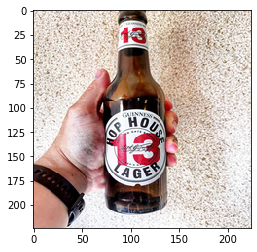

('guinness', <matplotlib.image.AxesImage object at 0x7f1065a88898>)


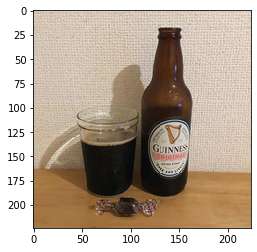

('heineken', <matplotlib.image.AxesImage object at 0x7f1065c0f2b0>)


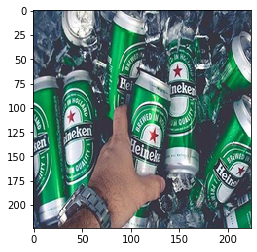

('guinness', <matplotlib.image.AxesImage object at 0x7f105f491b70>)


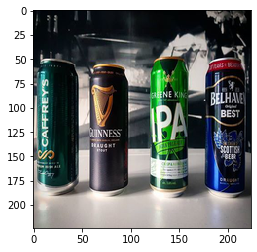

('guinness', <matplotlib.image.AxesImage object at 0x7f105f981978>)


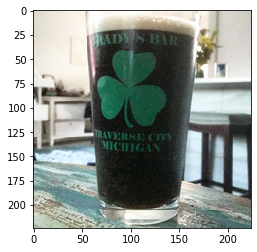

('guinness', <matplotlib.image.AxesImage object at 0x7f1064ea1470>)


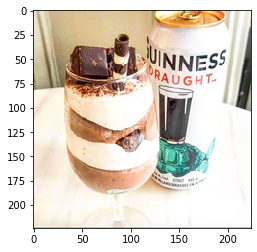

('hop-house', <matplotlib.image.AxesImage object at 0x7f10660dcd30>)


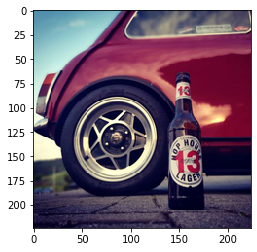

('guinness', <matplotlib.image.AxesImage object at 0x7f10661fbcf8>)


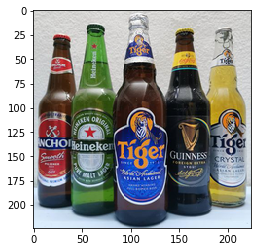

('corona', <matplotlib.image.AxesImage object at 0x7f1065ff6be0>)


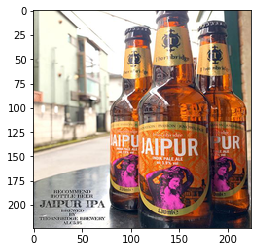

('guinness', <matplotlib.image.AxesImage object at 0x7f1065d5c630>)


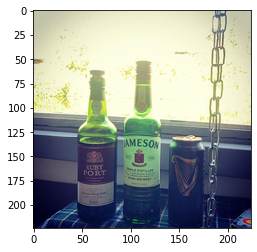

('guinness', <matplotlib.image.AxesImage object at 0x7f1065a413c8>)


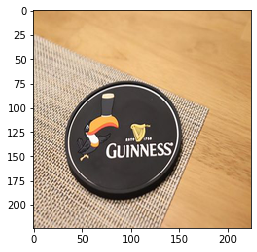

('guinness', <matplotlib.image.AxesImage object at 0x7f10659703c8>)


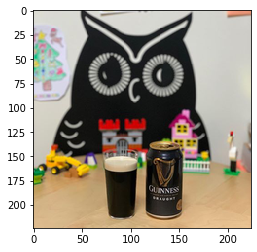

('guinness', <matplotlib.image.AxesImage object at 0x7f106553ca20>)


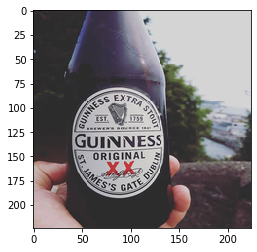

('hop-house', <matplotlib.image.AxesImage object at 0x7f10653409b0>)


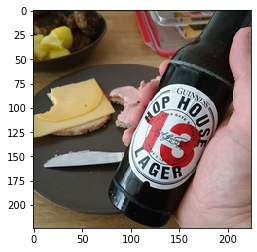

('guinness', <matplotlib.image.AxesImage object at 0x7f10651b8978>)


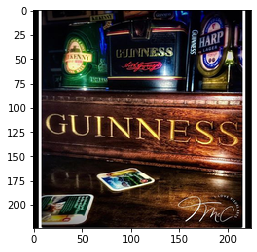

('guinness', <matplotlib.image.AxesImage object at 0x7f1064e3d710>)


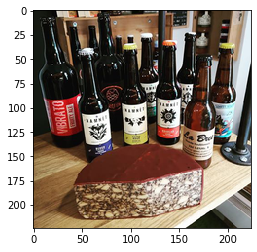

('corona', <matplotlib.image.AxesImage object at 0x7f1064bf4f28>)


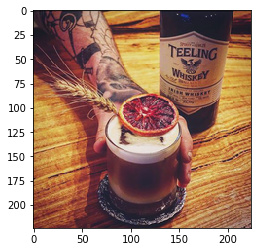

('guinness', <matplotlib.image.AxesImage object at 0x7f1064a27da0>)


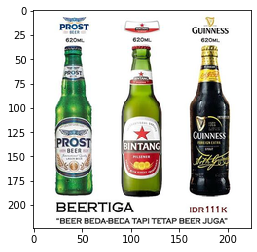

('guinness', <matplotlib.image.AxesImage object at 0x7f10645db6a0>)


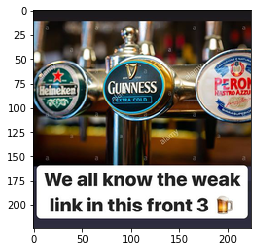

('guinness', <matplotlib.image.AxesImage object at 0x7f1064445160>)


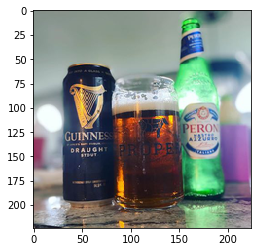

('guinness', <matplotlib.image.AxesImage object at 0x7f10643773c8>)


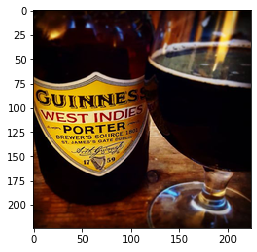

('no-logo', <matplotlib.image.AxesImage object at 0x7f105fe55b00>)


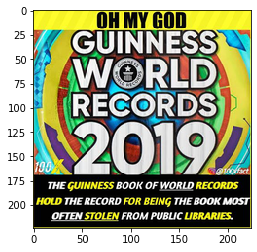

('hop-house', <matplotlib.image.AxesImage object at 0x7f105fe40400>)


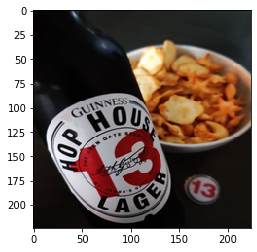

('guinness', <matplotlib.image.AxesImage object at 0x7f105fc69f60>)


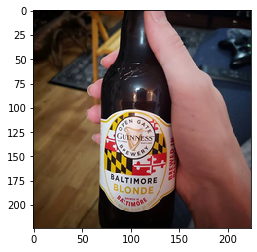

('hop-house', <matplotlib.image.AxesImage object at 0x7f105f702128>)


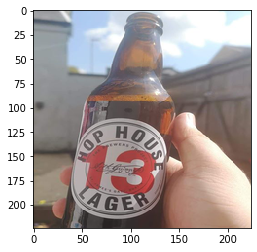

('guinness', <matplotlib.image.AxesImage object at 0x7f105f63d240>)


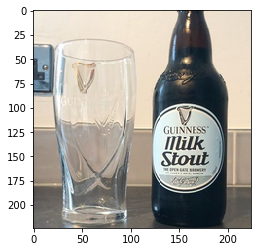

('hop-house', <matplotlib.image.AxesImage object at 0x7f105f30e390>)


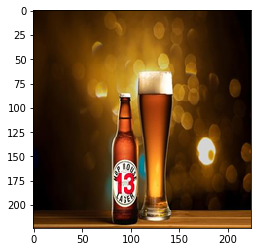

('guinness', <matplotlib.image.AxesImage object at 0x7f1065c8ca58>)


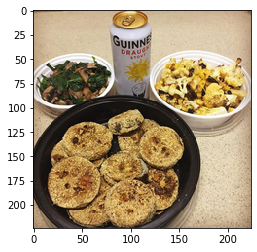

('carlsberg', <matplotlib.image.AxesImage object at 0x7f105fea5978>)


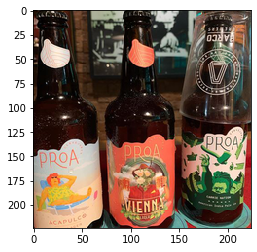

('hop-house', <matplotlib.image.AxesImage object at 0x7f105d390748>)


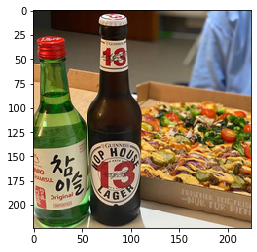

('guinness', <matplotlib.image.AxesImage object at 0x7f105cee3128>)


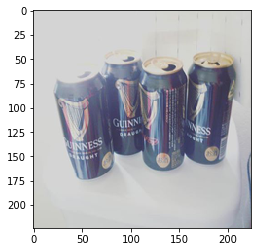

('guinness', <matplotlib.image.AxesImage object at 0x7f105e55bac8>)


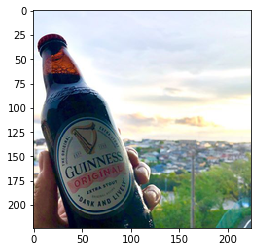

('guinness', <matplotlib.image.AxesImage object at 0x7f105cebd4a8>)


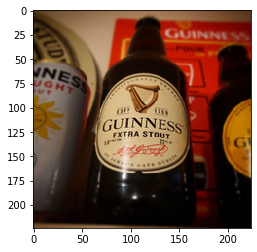

('guinness', <matplotlib.image.AxesImage object at 0x7f105cdd0e48>)


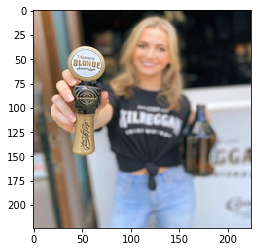

('heineken', <matplotlib.image.AxesImage object at 0x7f105cd70828>)


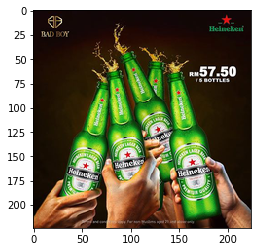

('hop-house', <matplotlib.image.AxesImage object at 0x7f105cc8d208>)


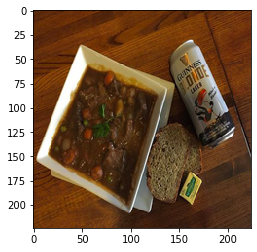

('guinness', <matplotlib.image.AxesImage object at 0x7f105cc22ba8>)


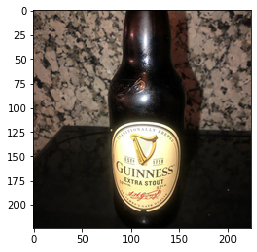

('guinness', <matplotlib.image.AxesImage object at 0x7f105cb44588>)


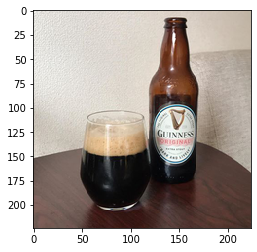

('guinness', <matplotlib.image.AxesImage object at 0x7f105caf5f28>)


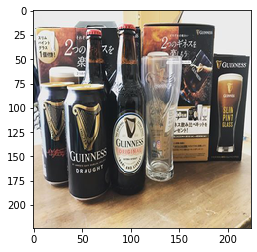

('guinness', <matplotlib.image.AxesImage object at 0x7f105ca2c908>)


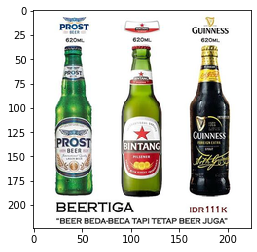

('guinness', <matplotlib.image.AxesImage object at 0x7f105c96a2e8>)


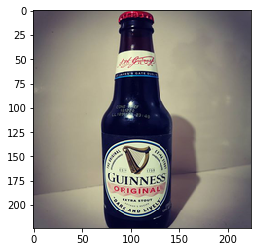

('guinness', <matplotlib.image.AxesImage object at 0x7f105c896828>)


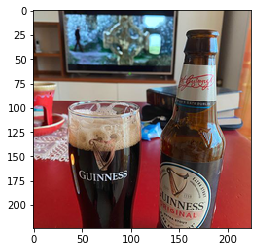

('guinness', <matplotlib.image.AxesImage object at 0x7f105c7d5208>)


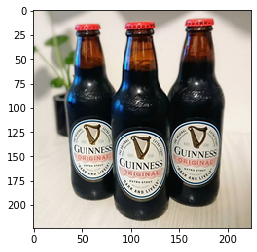

('guinness', <matplotlib.image.AxesImage object at 0x7f105c700ba8>)


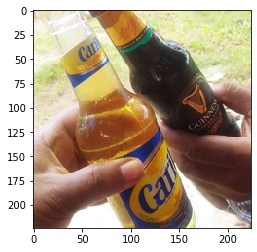

('guinness', <matplotlib.image.AxesImage object at 0x7f105c6be588>)


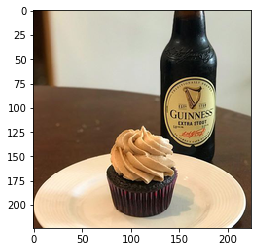

('guinness', <matplotlib.image.AxesImage object at 0x7f105c5eef28>)


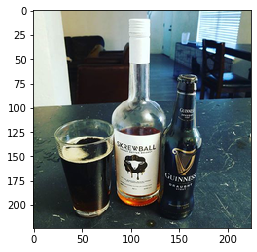

('fosters', <matplotlib.image.AxesImage object at 0x7f105c527908>)


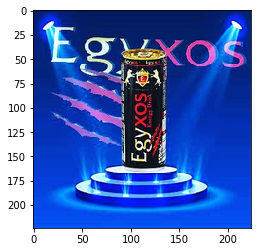

('no-logo', <matplotlib.image.AxesImage object at 0x7f105c4632e8>)


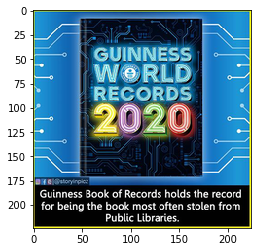

('guinness', <matplotlib.image.AxesImage object at 0x7f105c392c88>)


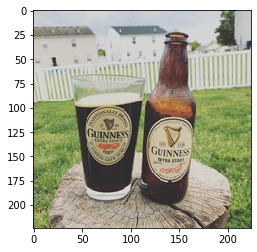

('guinness', <matplotlib.image.AxesImage object at 0x7f105c2cd668>)


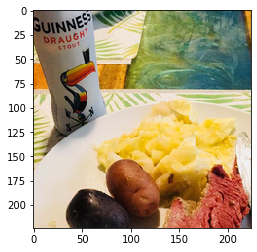

('paulaner', <matplotlib.image.AxesImage object at 0x7f105c27cfd0>)


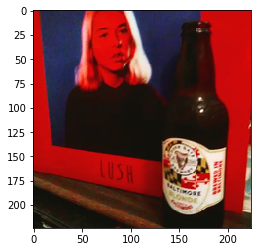

('guinness', <matplotlib.image.AxesImage object at 0x7f105c1b59e8>)


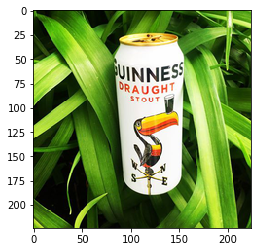

('guinness', <matplotlib.image.AxesImage object at 0x7f105c0f13c8>)


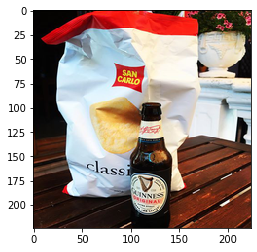

('guinness', <matplotlib.image.AxesImage object at 0x7f105c021d68>)


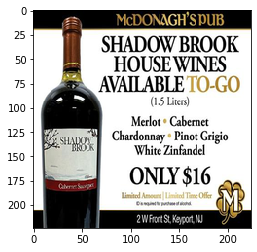

('guinness', <matplotlib.image.AxesImage object at 0x7f105bf5c748>)


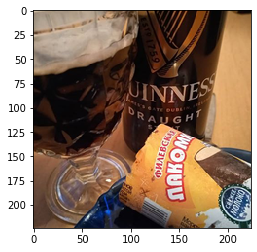

('guinness', <matplotlib.image.AxesImage object at 0x7f105be96128>)


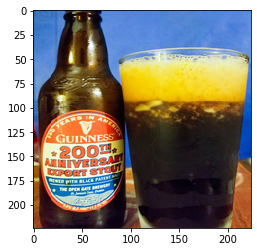

In [68]:
for i in urls_guinness:
    print(beer_logo(i[0], model_v3, labels))
    plt.show()
    

hop-house
hop-house
2020-05-09 12:53:32
hop-house
guinness
2020-05-09 12:09:09
heineken
heineken
2020-05-08 09:04:05
carlsberg
guinness
2020-05-08 21:23:33
guiness
guinness
2020-05-09 00:01:22
hop-house
guinness
2020-05-08 15:49:19
hop-house
hop-house
2020-05-08 17:52:48
heineken
guinness
2020-05-09 06:42:35
carlsberg
corona
2020-05-09 06:16:00
corona
guinness
2020-05-08 15:54:53
carlsberg
guinness
2020-05-07 12:48:09
guiness
guinness
2020-05-07 11:57:19
hop-house
guinness
2020-05-08 16:10:22
hop-house
hop-house
2020-05-07 16:54:36
heineken
guinness
2020-05-10 22:18:33
corona
guinness
2020-05-09 08:37:30
corona
corona
2020-05-12 16:56:38
hop-house
guinness
2020-05-09 23:19:07
heineken
guinness
2020-05-10 08:50:33
corona
guinness
2020-05-12 22:55:56
corona
guinness
2020-05-10 19:28:01
fosters
no-logo
2020-05-09 11:50:24
hop-house
hop-house
2020-05-10 18:32:46
becks
guinness
2020-05-11 04:19:56
hop-house
hop-house
2020-05-08 14:58:20
corona
guinness
2020-05-11 17:56:19
hop-house
hop-hous

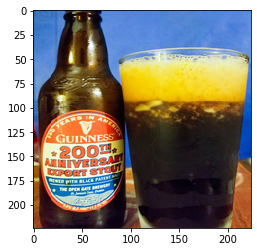

In [74]:
for i in urls_guinness:
    print(i[2])
    logo = beer_logo(i[0], model_v3, labels)[0]
    print(logo)
    date_time = str(pd.to_datetime(i[1])) 
    print(date_time)    
    PG.execute(f"""update guinness set logos='{logo}' where date_time = '{date_time}' """)